In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [27]:
df = pd.read_csv("movie_dataset.csv")
df.head()

,id,title,genre,overview,rating,release_date
0,278,The Shawshank Redemption,"Drama,Crime",Framed in the 1940s for the double murder of h...,8.7,1994-09-23
1,19404,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance","Raj is a rich, carefree, happy-go-lucky second...",8.7,1995-10-19
2,238,The Godfather,"Drama,Crime","Spanning the years 1945 to 1955, a chronicle o...",8.7,1972-03-14
3,424,Schindler's List,"Drama,History,War",The true story of how businessman Oskar Schind...,8.6,1993-12-15
4,240,The Godfather: Part II,"Drama,Crime",In the continuing saga of the Corleone crime f...,8.6,1974-12-20


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   title         10000 non-null  object 
 2   genre         9997 non-null   object 
 3   overview      9987 non-null   object 
 4   rating        10000 non-null  float64
 5   release_date  10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [29]:
df.isnull().sum()

id               0
title            0
genre            3
overview        13
rating           0
release_date     0
dtype: int64

In [30]:
df.describe()

,id,rating
count,10000.000000,10000.000000
mean,161243.505000,6.621150
std,211422.046043,0.766231
min,5.000000,4.600000
25%,10127.750000,6.100000
50%,30002.500000,6.600000
75%,310133.500000,7.200000
max,934761.000000,8.700000


In [31]:
df['genre_content'] = df['genre'].str.replace(',', ' ', regex=False)

df['genre_content'] = df['genre_content'].fillna("")

In [32]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(df['genre_content'])

In [33]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [34]:
def recommend_movies(movie_title, top_n=10, min_similarity=0.1, sim_weight=0.7, rating_weight=0.3):
    if movie_title not in indices:
        return f"Movie '{movie_title}' not found in dataset"
    
    idx = indices[movie_title]
    if isinstance(idx, (list, pd.Series, np.ndarray)):
        idx = int(idx.iloc[0])
    else:
        idx = int(idx)
    
    similarity_scores = linear_kernel(tfidf_matrix[idx:idx+1], tfidf_matrix).flatten()
    similarity_scores[idx] = 0
    
    temp_df = df.assign(similarity=similarity_scores)
    temp_df = temp_df[temp_df['similarity'] >= min_similarity]
    
    temp_df['rating'] = temp_df['rating'].fillna(temp_df['rating'].mean())
    temp_df['normalized_rating'] = temp_df['rating'] / 10.0
    
    temp_df['weighted_score'] = (sim_weight * temp_df['similarity']) + (rating_weight * temp_df['normalized_rating'])
    
    result = temp_df[['title', 'genre', 'rating', 'similarity', 'weighted_score', 'release_date']] \
                .sort_values(by='weighted_score', ascending=False) \
                .head(top_n).copy()
    
    result['release_date'] = result['release_date'].fillna('Unknown')
    result['similarity'] = result['similarity'].round(3)
    result['weighted_score'] = result['weighted_score'].round(3)
    
    return result


In [36]:
recommend_movies("The Avengers", 10)

,title,genre,rating,similarity,weighted_score,release_date
54,Inception,"Action,Sci-Fi,Adventure",8.4,1.0,0.952,2010-07-15
42,The Empire Strikes Back,"Adventure,Action,Sci-Fi",8.4,1.0,0.952,1980-05-20
96,Avengers: Infinity War,"Adventure,Action,Sci-Fi",8.3,1.0,0.949,2018-04-25
86,Avengers: Endgame,"Adventure,Sci-Fi,Action",8.3,1.0,0.949,2019-04-24
99,Everything Everywhere All at Once,"Action,Adventure,Sci-Fi",8.3,1.0,0.949,2022-03-24
134,Star Wars,"Adventure,Action,Sci-Fi",8.2,1.0,0.946,1977-05-25
258,Spider-Man: No Way Home,"Action,Adventure,Sci-Fi",8.1,1.0,0.943,2021-12-15
374,The Tomorrow War,"Action,Sci-Fi,Adventure",8.0,1.0,0.940,2021-07-02
445,Return of the Jedi,"Adventure,Action,Sci-Fi",7.9,1.0,0.937,1983-05-25
443,Guardians of the Galaxy,"Action,Sci-Fi,Adventure",7.9,1.0,0.937,2014-07-30


Rating Distribution

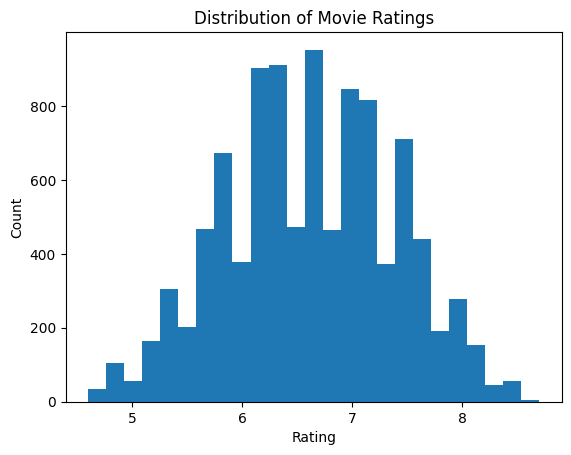

In [37]:
plt.hist(df['rating'], bins=25)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Top Genres Frequency

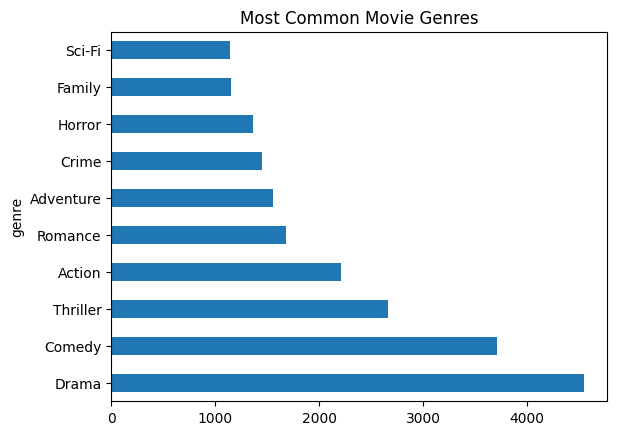

In [39]:
df['genre'].str.split(',').explode().value_counts().head(10).plot(kind='barh')
plt.title("Most Common Movie Genres")
plt.show()

Recommendation Result Visualization

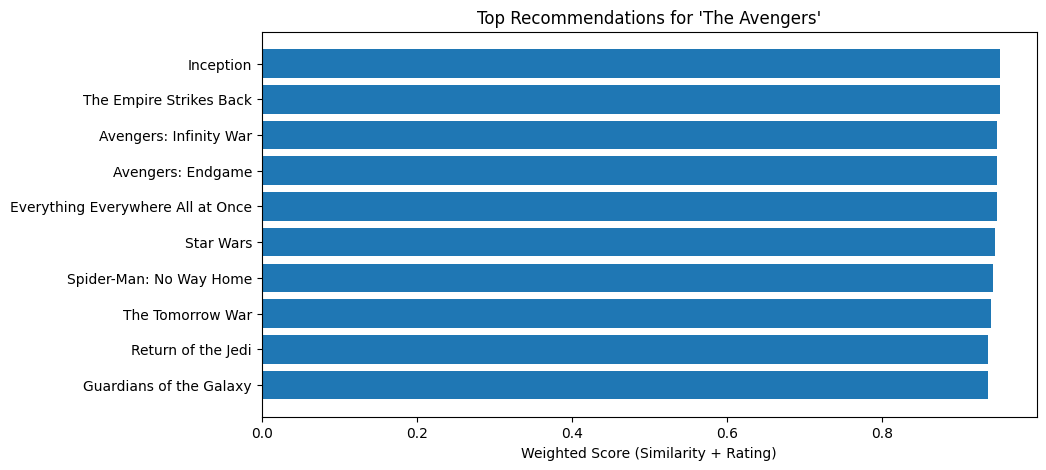

In [40]:
movie_name = "The Avengers"
result = recommend_movies(movie_name, top_n=10)

plt.figure(figsize=(10,5))
plt.barh(result['title'], result['weighted_score'])
plt.xlabel("Weighted Score (Similarity + Rating)")
plt.title(f"Top Recommendations for '{movie_name}'")
plt.gca().invert_yaxis()
plt.show()

Stacked Contribution Plot

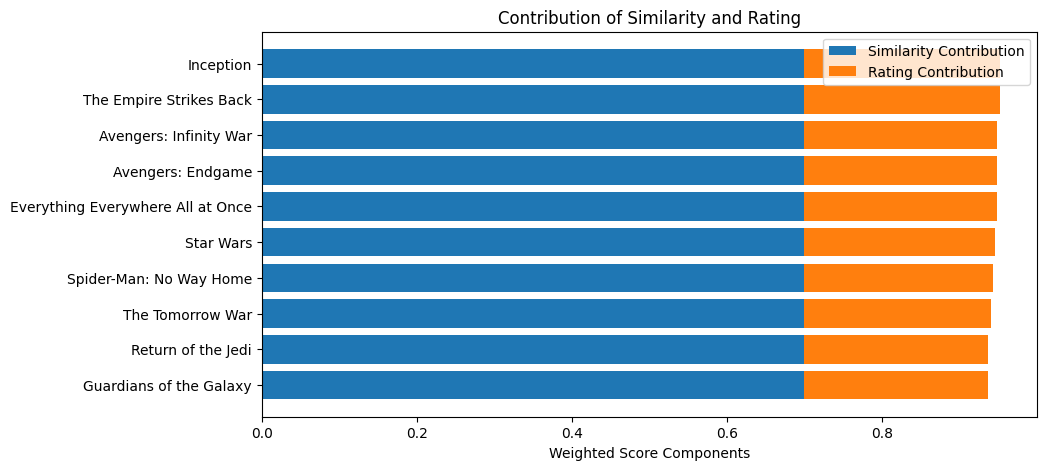

In [41]:
sim_weight = 0.7
rating_weight = 0.3

sim_part = sim_weight * result['similarity']
rating_part = rating_weight * (result['rating'] / 10.0)

plt.figure(figsize=(10,5))
plt.barh(result['title'], sim_part, label='Similarity Contribution')
plt.barh(result['title'], rating_part, left=sim_part, label='Rating Contribution')

plt.xlabel("Weighted Score Components")
plt.title("Contribution of Similarity and Rating")
plt.legend()
plt.gca().invert_yaxis()
plt.show()